<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be



---



### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
# УБИРАЕМ ТАБУЛЯЦИЮ!


for sentence in tqdm(dataset['train']['text']):
    clean_sentence = sentence.replace("<br/>", " ")
    sentences.extend(
        [x.lower() for x in sent_tokenize(clean_sentence, language='english') if len(x.split(' ')) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 219936


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence.lower()):  # Токенизируем текст
        words[word] += 1

  0%|          | 0/219936 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
words.most_common(10)

[('.', 189247),
 ('the', 184787),
 (',', 147978),
 ('a', 91409),
 ('and', 89334),
 ('of', 77075),
 ('to', 73660),
 ('is', 68245),
 ('it', 61120),
 ('i', 57367)]

In [11]:
# составляем словарь bos - beggining, eos - end, pad - прямоугольная форма в батчах  (просто добавляем паддинг справа/слева, чтобы предложения были одной длины)
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
most_common_words = words.most_common(vocab_size)
for word, idx in most_common_words:
    vocab.add(word)

In [12]:
vocab_size

40000

In [13]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [14]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004




---



### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [15]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [16]:
class WordDataset:
    def __init__(self, sentences):
      # не забываем и здесь поменять токенизацию по словам, а не буквам. убираем табуляцию
        self.data = [word_tokenize(sentence.replace("< br / >", " ").lower()) for sentence in sentences]
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # возвращает токенизированную последовательность - в начало ставит бос, потом слова меняем на индексы, в конце добавляем еос.
        tokenized_sentence = []
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)



In [17]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    # добавляет паддинги до самой длинной последовательности в этом батче.
    # и закидывает нью батч на девайс
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        # все токены до последнего
        'input_ids': sequences[:,:-1],
        # таргеты - все токены, сдвинутые на единицу вправо (т.е. следующие слова)
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [18]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
for x in test_dataloader:
  print([ind2word[w.item()] for w in x['input_ids'][50]])
  break

['<bos>', 'it', 'is', 'a', 'film', 'with', 'a', 'gay', 'character', ',', 'i', 'ca', "n't", 'see', 'why', 'every', 'film', 'with', 'a', 'gay', 'character', 'should', 'be', 'strictly', 'a', 'film', 'about', 'being', 'gay', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']




---



## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!



---



### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [19]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
           # Посчитайте логиты предсказаний следующих слов
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [20]:
def train_model(model, num_ep, opt, cr, save_path="model.pth"):
    num_epoch = num_ep
    optimizer = opt
    criterion = cr
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        # средний loss за эпоху
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)

        # вычисляем перплексию
        perplexity = evaluate(model, criterion, train_dataloader)
        perplexities.append(perplexity)

        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Perplexity = {perplexity:.4f}")

    # строим графики
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(np.arange(len(losses)), losses, label="Loss")
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(np.arange(len(perplexities)), perplexities, label="Perplexity", color='red')
    ax[1].set_title('Training Perplexity')
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Perplexity")
    ax[1].legend()

    plt.show()

    # сохранили модель
    torch.save(model.state_dict(), save_path)
    print(f"Модель сохранена в {save_path}")

    return losses, perplexities

# чтобы подгрузить
def load_model(model, path="model.pth"):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Модель загружена из {path}")
    return model



---



### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.
GRU+64 hidden_dim +Adam

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
         #  батч ферст - говорим о том, что размерность батча первая
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
          #  отображаем в размер словаря
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]
        return projection

Training epoch 0::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 0: Loss = 5.6853, Perplexity = 174.2225


Training epoch 1::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 1: Loss = 5.0927, Perplexity = 138.9397


Training epoch 2::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 2: Loss = 4.9405, Perplexity = 123.1838


Training epoch 3::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 3: Loss = 4.8491, Perplexity = 113.5817


Training epoch 4::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 4: Loss = 4.7847, Perplexity = 107.1296


Training epoch 5::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 5: Loss = 4.7358, Perplexity = 102.1511


Training epoch 6::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 6: Loss = 4.6959, Perplexity = 98.1852


Training epoch 7::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 7: Loss = 4.6632, Perplexity = 95.0135


Training epoch 8::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 8: Loss = 4.6350, Perplexity = 92.3388


Training epoch 9::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 9: Loss = 4.6100, Perplexity = 90.1621


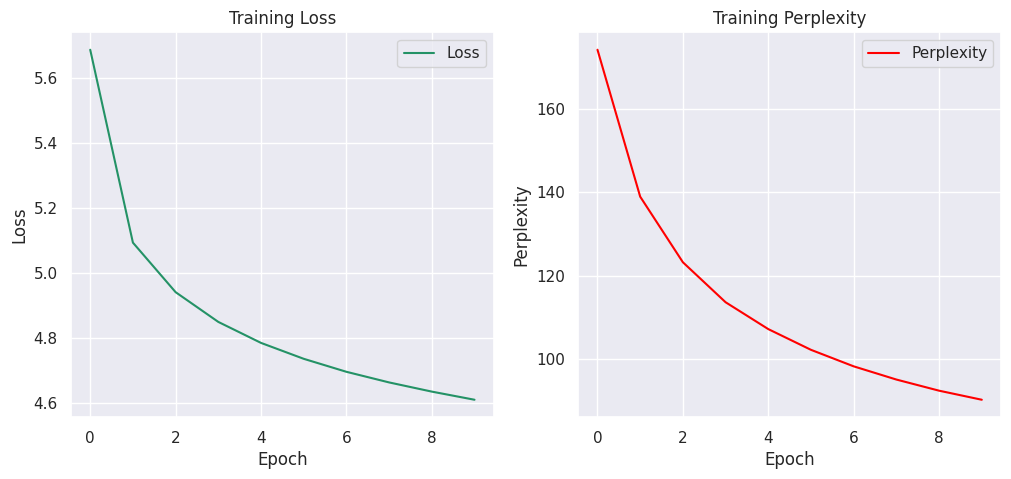

Модель сохранена в model1.pth


([5.685264402909713,
  5.0926740930730645,
  4.940506067102605,
  4.849114714882591,
  4.784654873241077,
  4.735790133562955,
  4.69585465778004,
  4.663206614754417,
  4.6349961570392955,
  4.6099958503029566],
 [174.2225094909668,
  138.93969963212447,
  123.18377663629705,
  113.58167882191051,
  107.12955455433239,
  102.15114505837181,
  98.18521807861327,
  95.01348886940696,
  92.33879253595525,
  90.16210752175071])

In [ ]:
 # Обучите модель здесь
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab)).to(device)
# по токену пад считать лосс не надо, тк он служебный
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
train_model(model,10,optimizer,criterion, save_path="model1.pth")


In [ ]:
print("Перплексия:",evaluate(model.eval(),criterion,eval_dataloader))

Перплексия: 121.33522386329119


In [30]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 50) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        # обязательно не забываем токенизировать ПО СЛОВАМ!
        word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
              # если он является служебкой последней, то прекращаем генерировать
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words[6:-6]

In [ ]:
generate_sequence(model, starting_seq='my')

'my favorite character is a great actor , but the film is a very good movie .'

In [ ]:
generate_sequence(model, starting_seq='i love')

"i love the movie , but i 'm not sure that i have to say that it was a good movie ."

In [ ]:
generate_sequence(model, starting_seq='the worst')

'the worst movie ever made .'

In [ ]:
generate_sequence(model, starting_seq='plot is amazing and i sure that ')

'plot is amazing and i sure that i have seen this movie .'



---



### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Подставим 2 RNN слоя вместо GRU

In [22]:
# Проведите второй эксперимент
class Rnn(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
         #  батч ферст - говорим о том, что размерность батча первая
        self.rnn = nn.RNN(hidden_dim, hidden_dim,batch_first=True,num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
          #  отображаем в размер словаря
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]
        return projection

Training epoch 0::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 0: Loss = 5.4169, Perplexity = 145.2578


Training epoch 1::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 1: Loss = 4.9140, Perplexity = 116.8389


Training epoch 2::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 2: Loss = 4.7623, Perplexity = 103.8345


Training epoch 3::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 3: Loss = 4.6650, Perplexity = 95.4575


Training epoch 4::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 4: Loss = 4.5927, Perplexity = 89.8067


Training epoch 5::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 5: Loss = 4.5438, Perplexity = 85.3464


Training epoch 6::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 6: Loss = 4.4900, Perplexity = 81.4656


Training epoch 7::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 7: Loss = 4.6185, Perplexity = 88.4483


Training epoch 8::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 8: Loss = 4.5084, Perplexity = 79.7799


Training epoch 9::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 9: Loss = 4.4351, Perplexity = 76.7689


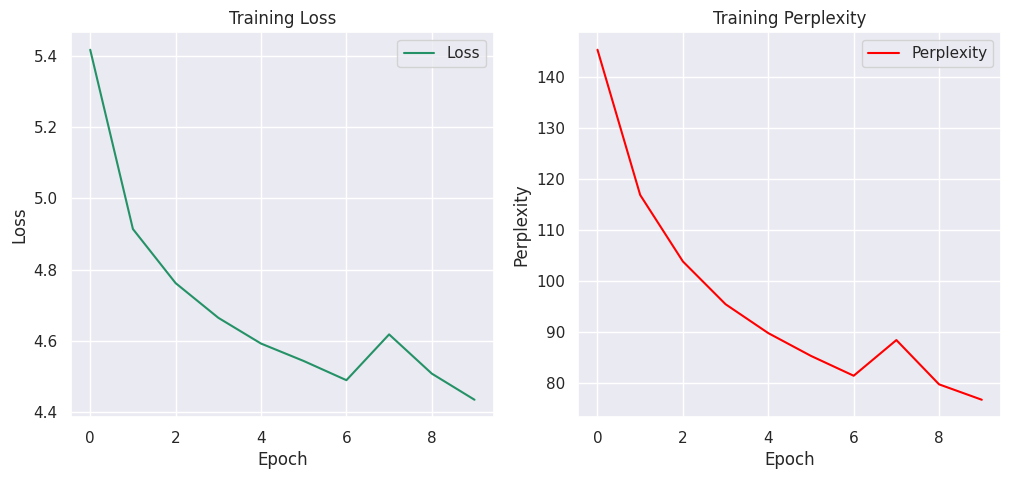

Модель сохранена в model2.pth


([5.416887463482944,
  4.914003517150879,
  4.762302673513239,
  4.665028450358998,
  4.592747593619607,
  4.543839262615551,
  4.490004478627985,
  4.618461046045477,
  4.5084229353991425,
  4.435132637804204],
 [145.25775967129795,
  116.8389213659113,
  103.83446396290172,
  95.45745820340244,
  89.8066553733132,
  85.34644642916592,
  81.46559573086826,
  88.44834765763716,
  79.77986094804244,
  76.76893132643266])

In [23]:
 # Обучите модель здесь
model2 = Rnn(hidden_dim=128, vocab_size=len(vocab)).to(device)
# по токену пад считать лосс не надо, тк он служебный
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters())
train_model(model2,10,optimizer,criterion, save_path="model2.pth")

In [24]:
print("Перплексия:",evaluate(model2.eval(),criterion,eval_dataloader))

Перплексия: 118.46834142818007


In [32]:
generate_sequence(model2, starting_seq='i love')

'i love this movie .'

In [33]:
generate_sequence(model2, starting_seq='this movie')

'this movie is a great movie .'

In [36]:
generate_sequence(model2, starting_seq='my money ')

'my money is a little bit of the story .'

In [40]:
generate_sequence(model2, starting_seq='i spend')

'i spend the time to see this movie .'

In [37]:
generate_sequence(model2, starting_seq='i would better')

'i would better recommend this movie .'

In [38]:
generate_sequence(model2, starting_seq='i never')

'i never saw this movie .'




---



### Третий эксперимент
SGD + lr 0.01 + RNN 2 layers - p.s. очень плохо

Training epoch 0::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 0: Loss = 8.1972, Perplexity = 1155.2313


Training epoch 1::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 1: Loss = 6.8634, Perplexity = 839.5127


Training epoch 2::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 2: Loss = 6.6451, Perplexity = 702.7579


Training epoch 3::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 3: Loss = 6.4652, Perplexity = 589.0815


Training epoch 4::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 4: Loss = 6.3227, Perplexity = 531.1059


Training epoch 5::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 5: Loss = 6.2343, Perplexity = 493.6539


Training epoch 6::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 6: Loss = 6.1673, Perplexity = 465.1848


Training epoch 7::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 7: Loss = 6.1124, Perplexity = 442.5436


Training epoch 8::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 8: Loss = 6.0648, Perplexity = 423.2688


Training epoch 9::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 9: Loss = 6.0226, Perplexity = 406.4133


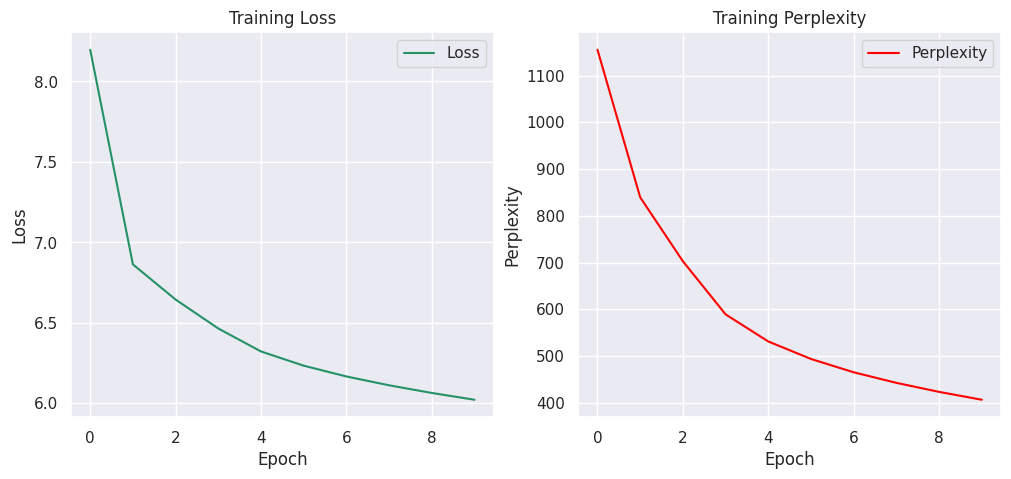

Модель сохранена в model3.pth


([8.197191191413186,
  6.863428359811956,
  6.645109953620217,
  6.465225159384987,
  6.3226688369404185,
  6.234254645607688,
  6.16728595681624,
  6.112377766869285,
  6.0648062764948065,
  6.022643709702925],
 [1155.2313218439276,
  839.5126908291903,
  702.7578786177202,
  589.0814524702593,
  531.1059449906783,
  493.65389612926134,
  465.1847801513672,
  442.54356473055753,
  423.26876806640627,
  406.413306529652])

In [27]:
 # Обучите модель здесь
model3 = Rnn(hidden_dim=128, vocab_size=len(vocab)).to(device)
# по токену пад считать лосс не надо, тк он служебный
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.SGD(model3.parameters(), lr=0.01)
train_model(model3,10,optimizer,criterion, save_path="model3.pth")

In [28]:
print("Перплексия:",evaluate(model3.eval(),criterion,eval_dataloader))

Перплексия: 410.27733372533044


очень плохие результаты. использовать не буду.



---



### Четвертый эксперимент
GRU + 128 hidden_dim + 0.2 Dropout

In [41]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
         #  батч ферст - говорим о том, что размерность батча первая
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
          #  отображаем в размер словаря
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]
        return projection

Training epoch 0::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 0: Loss = 5.4146, Perplexity = 143.8494


Training epoch 1::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 1: Loss = 4.9048, Perplexity = 113.4837


Training epoch 2::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 2: Loss = 4.7511, Perplexity = 100.5496


Training epoch 3::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 3: Loss = 4.6551, Perplexity = 92.0838


Training epoch 4::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 4: Loss = 4.5850, Perplexity = 86.4868


Training epoch 5::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 5: Loss = 4.5299, Perplexity = 81.9267


Training epoch 6::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 6: Loss = 4.4854, Perplexity = 78.1790


Training epoch 7::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 7: Loss = 4.4472, Perplexity = 75.4655


Training epoch 8::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 8: Loss = 4.4138, Perplexity = 73.4132


Training epoch 9::   0%|          | 0/2750 [00:00<?, ?it/s]

Epoch 9: Loss = 4.3847, Perplexity = 71.2425


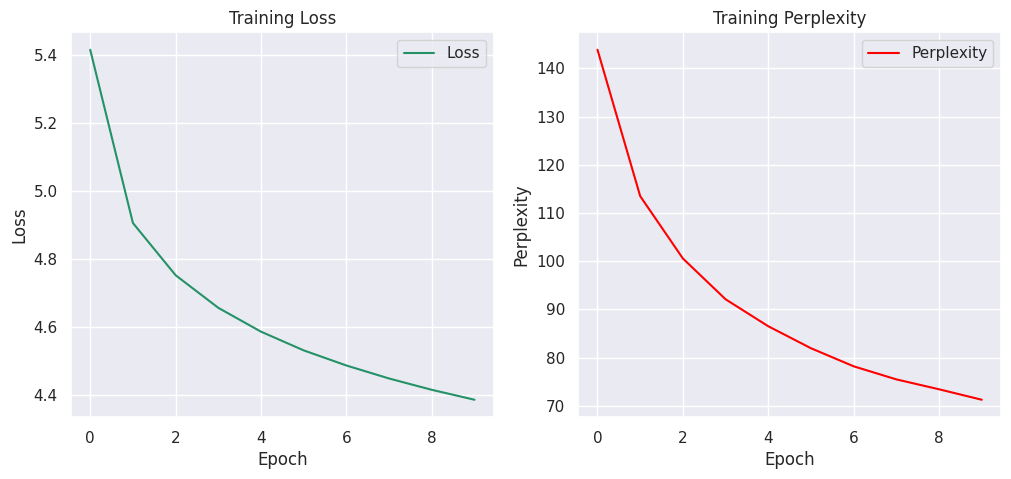

Модель сохранена в model4.pth


([5.4146011153134435,
  4.904770496368408,
  4.7511056653803045,
  4.655122104991566,
  4.584984074072405,
  4.529924114574086,
  4.48544806653803,
  4.447185796564275,
  4.413848909291354,
  4.384658186218955],
 [143.84940554809572,
  113.48374839643999,
  100.5496070542769,
  92.08379701649059,
  86.48684203685414,
  81.9267438992587,
  78.17895217201927,
  75.46553313515403,
  73.41320874023438,
  71.2425243023959])

In [42]:
 # Обучите модель здесь
model4 = LanguageModel(hidden_dim=128, vocab_size=len(vocab)).to(device)
# по токену пад считать лосс не надо, тк он служебный
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model4.parameters())
train_model(model4,10,optimizer,criterion, save_path="model4.pth")

In [43]:
print("Перплексия:",evaluate(model4.eval(),criterion,eval_dataloader))

Перплексия: 119.35266794160356


In [46]:
generate_sequence(model4, starting_seq='i love')

'i love the movie .'

In [52]:
generate_sequence(model4, starting_seq='amazing, i think that')

"amazing , i think that it 's a great movie ."

In [54]:
generate_sequence(model4, starting_seq='bad actor')

'bad actor , and the rest of the cast is very good .'

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

В целом, GRU-модели работают лучше. Очень плохо работают оптимизаторы, использующие градиентный спуск (обычный). Можно попробовать увеличить размер батча (на мощном железе), размерность скрытых слоев, использовать другие оптимизаторы (но с некоторыми результат будет гораздо хуже, к сожалению).

По итогу, модель номер 2, использующая два слоя RNN и размерность слоя в 128 единиц показывает наилучшую метрику, равную 118. На втором месте находится GRU-модель номер 4 с Dropout-ом,равным 0.2 и метрикой 119 на оценочном датасете.

Методы в экспериментах были описаны под названями самих экспериментов.